In [16]:
import os
import numpy as np
from numba import njit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score

In [2]:
folder_path = "C:/Users/Aiden/Downloads/archive (1)/EEG_data"
all_data = []
ppid = 0
with os.scandir(folder_path) as groups:
    for group in groups: # loop through all the folders
        with os.scandir(group) as files:
            for file in files: # loop through all the files
                ppid += 1 
                print(f"{file.name} --> pp{ppid}")
                prefix = file.name[:2] # selects only the first 2 letters of the filename in order to determine the group
                df = pd.read_csv(file.path)
                if df.shape[1] < 40: # fills in any missing channels
                    for channel in range(40):
                        if str(channel) not in list(df.columns):
                            df[str(channel)] = np.nan
                df = df.iloc[:, :40] # gets rid of any excess channels
                df.columns = list(range(1, 41)) # standardises the naming just in case, ready for concatenation
                df["id"] = ppid
                if prefix == "Mi":
                    df["Category"] = 1
                elif prefix == "Mo":
                    df["Category"] = 2
                elif prefix == "Sv":
                    df["Category"] = 3
                all_data.append(df)
combined_df = pd.concat(all_data, ignore_index=True)

Mild1.csv --> pp1
Mild2.csv --> pp2
Mild3.csv --> pp3
Mild4.csv --> pp4
Mild5.csv --> pp5
Mild6.csv --> pp6
Mild7.csv --> pp7
Mild8.csv --> pp8
Mod1.csv --> pp9
Mod10.csv --> pp10
Mod11.csv --> pp11
Mod12.csv --> pp12
Mod2.csv --> pp13
Mod3.csv --> pp14
Mod4.csv --> pp15
Mod5.csv --> pp16
Mod6.csv --> pp17
Mod7.csv --> pp18
Mod8.csv --> pp19
Mod9.csv --> pp20
Sv1.csv --> pp21
Sv10.csv --> pp22
Sv2.csv --> pp23
Sv3.csv --> pp24
Sv4.csv --> pp25
Sv5.csv --> pp26
Sv6.csv --> pp27
Sv7.csv --> pp28
Sv8.csv --> pp29
Sv9.csv --> pp30


In [3]:
window_sec = 2.0 # in seconds
overlap_sec = 1.0 # in seconds
fs = 250 # sampling frequency in Hz

# windowing
windows = []
for pid, group in combined_df.groupby("id"):
    data = group.iloc[:, :-2].to_numpy()  # all EEG channels - not the category and id
    n_samps = data.shape[0] # total number of samples
    win_samps = int(window_sec * fs) # number of samples per window
    step = int((window_sec - overlap_sec) * fs)
    indices = range(0, n_samps - win_samps + 1, step)
    for start in indices:
        window = data[start:start+win_samps, :] # puts the corrosponding subset of the data in its window
        windows.append((pid, window, group["Category"].iloc[0]))

In [5]:
# extract features per window
feat_names = ["mean","std","var","skew","kurtosis","rms","energy","zcr","ptp",
              "hjorth_activity","hjorth_mobility","hjorth_complexity"]
features = []
for w in windows:
    pid = w[0]
    window_data = w[1]
    category = w[2]

    feature = {"id": pid, "category": category}
    
    # per-channel features
    for ch_idx in range(window_data.shape[1]):
        x = window_data[:, ch_idx]
        feats = compute_stat_features(x)
        for i, val in enumerate(feats):
            feature[f"{ch_idx+1}_{feat_names[i]}"] = val
    features.append(feature)

feat_df = pd.DataFrame.from_records(features)

In [6]:
@njit # using this library makes doing all the calculations much much faster
def compute_stat_features(x):
    feats = np.zeros(12)
    # basic stats
    feats[0] = np.mean(x)
    feats[1] = np.std(x)
    feats[2] = np.var(x)
    
    # skew and kurtosis
    if feats[1] > 0:
        feats[3] = np.sum((x - feats[0])**3) / (len(x) * feats[1]**3)
        feats[4] = np.sum((x - feats[0])**4) / (len(x) * feats[2]**2) - 3
    else:
        feats[3] = 0.0
        feats[4] = 0.0
    
    # rms, energy, zcr, ptp
    feats[5] = np.sqrt(np.mean(x**2))
    feats[6] = np.sum(x**2)
    feats[7] = ((x[:-1]*x[1:]) < 0).sum() / len(x)
    feats[8] = np.ptp(x)
    
    # Hjorth parameters
    diff1 = np.diff(x)
    diff2 = np.diff(diff1)
    var0 = feats[2]
    var1 = np.var(diff1)
    var2 = np.var(diff2)
    
    feats[9] = var0  # activity
    feats[10] = np.sqrt(var1 / var0) if var0 > 1e-12 else 0.0  # mobility
    feats[11] = np.sqrt((var2/var1) / (var1/var0)) if (var0 > 1e-12 and var1 > 1e-12) else 0.0  # complexity

    return feats

In [19]:
test_subject_ratio = 0.3
feature_cols = list(feat_df.columns)[2:] # maes sure we dont tell the model the label as the data!
ppids = feat_df["id"].unique()
# statify by participant so partcipants in the training are not in the test set
train_ppids, test_ppids = train_test_split(ppids, test_size=test_subject_ratio, stratify=[feat_df.loc[feat_df['id']==p, 'category'].iloc[0] for p in ppids], random_state=0)
train_df = feat_df[feat_df["id"].isin(train_ppids)]
test_df = feat_df[feat_df["id"].isin(test_ppids)]

# impute any missing values so the model can actually run
imputer = SimpleImputer(strategy="median")
train_df_imputed = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns)
test_df_imputed = pd.DataFrame(imputer.transform(test_df), columns=test_df.columns)

X_train = train_df_imputed[feature_cols].values
y_train = train_df_imputed["category"].values
X_test = test_df_imputed[feature_cols].values
y_test = test_df_imputed["category"].values

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
model = LogisticRegression(
    solver="saga",          # chosen because saga handles large datasets efficiently
    max_iter=5000,          
    class_weight="balanced",
    random_state=0
)
model.fit(X_train_scaled, y_train) # train the model

# Predictions & Evaluation
y_pred_lr = model.predict(X_test_scaled)
y_prob_lr = model.predict_proba(X_test_scaled)

print("done :)")

done :)



 LOGISTIC REGRESSION CLASSIFICATION REPORT

              precision    recall  f1-score   support

         1.0       0.96      1.00      0.98      4798
         2.0       1.00      0.83      0.91      6825
         3.0       0.84      0.99      0.91      5129

    accuracy                           0.93     16752
   macro avg       0.93      0.94      0.93     16752
weighted avg       0.94      0.93      0.93     16752

ROC AUC Score: 0.989587


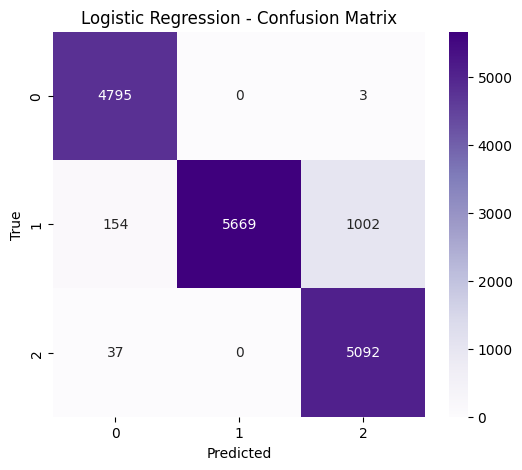

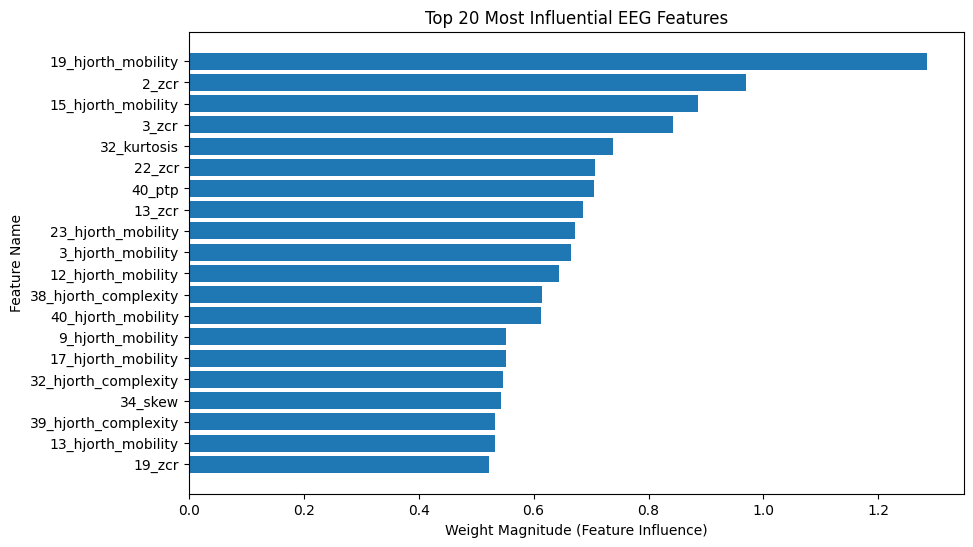

In [18]:
print("\n LOGISTIC REGRESSION CLASSIFICATION REPORT\n")
print(classification_report(y_test, y_pred_lr))

auc_lr = roc_auc_score(y_test, y_prob_lr, multi_class="ovr", average="weighted")
print(f"ROC AUC Score: {auc_lr:.6f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Purples")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Feature Weight Importance (Top 20 by absolute magnitude)
coeffs = np.abs(model.coef_).mean(axis=0)  # mean importance across classes
sorted_idx = np.argsort(coeffs)[-20:]       # top 20 strongest features

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_cols)[sorted_idx], coeffs[sorted_idx])
plt.title("Top 20 Most Influential EEG Features")
plt.xlabel("Weight Magnitude (Feature Influence)")
plt.ylabel("Feature Name")
plt.show()

In [17]:
# Train Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=600,       # number of trees
    max_depth=None,         # allow tree to grow fully
    class_weight="balanced",# handles class imbalance
    random_state=0,
    n_jobs=-1              
)

rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)


 RANDOM FOREST CLASSIFICATION REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      4798
         2.0       1.00      0.71      0.83      6825
         3.0       0.72      1.00      0.84      5129

    accuracy                           0.88     16752
   macro avg       0.91      0.90      0.89     16752
weighted avg       0.91      0.88      0.88     16752

ROC AUC Score: 0.998006


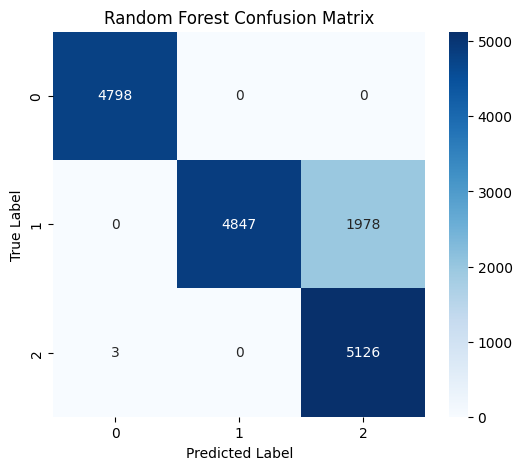

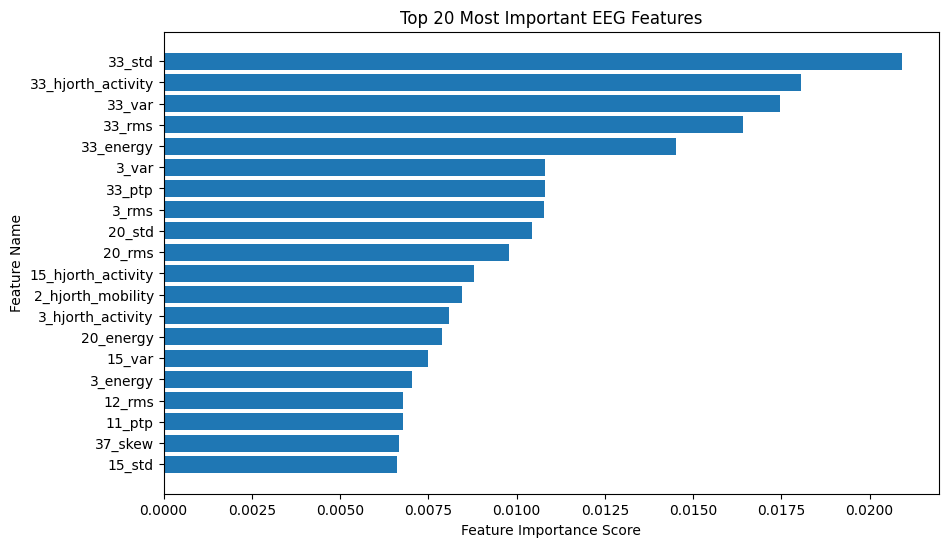

In [14]:
# Evaluation
print("\n RANDOM FOREST CLASSIFICATION REPORT\n")
print(classification_report(y_test, y_pred_rf))

auc = roc_auc_score(y_test, y_prob_rf, multi_class="ovr", average="weighted")
print(f"ROC AUC Score: {auc:.6f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Feature Importance
feat_importance = rf.feature_importances_
sorted_idx = np.argsort(feat_importance)[-20:]  # top 20 features

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_cols)[sorted_idx], feat_importance[sorted_idx])
plt.title("Top 20 Most Important EEG Features")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.show()